## Notebook for waveform generation

This notebook generates the waveform as per Appendix A requirement.


In [1]:
import platform
import numpy as np
import matplotlib.pyplot as plt
import sys


First we print out relevant package version. This notebook has been run using [lusee/lusee-night-unity-luseepy:1.0](https://hub.docker.com/layers/lusee/lusee-night-unity-luseepy/1.0/images/sha256-a9fb9b47e1f300025995fc35c917ba865725285fa52a61c58920540a25439559?context=explore) Docker image. Stick to that for maximum compatibility. Run `ljupyter` as defined [here](https://github.com/lusee-night/luseepy/blob/main/setup_env.sh).

In [2]:
print ('Python version:', platform.python_version())
print ('Numpy version:', np.__version__)
try:
    assert(sys.byteorder=='little')
except:
    print ('Error: sys.byteorder is not little-endian')
    raise AssertionError

Python version: 3.10.1
Numpy version: 1.25.0


# Part 1: generating the waveform

Basic settings first:

In [3]:
filename = 'waveforms/calibrator_231001.bin'
N = 2048 # lenght of our waveform
seed = 20151023 # Brin's birthday


In [4]:
# Check our seed is OK
np.random.seed(seed) # set the seed of the random number generator
try:
    assert(np.random.randint(10000)==9291)
except AssertionError:
    print ("The first random number given seed is not what we expect. Check your numpy version / python environment.")

Now we generate the waveform.

In [5]:
# Generate a random waveform with unity amplitude and random phase
Nfft = N//2+1 # number of frequency bins
wave_fourier = np.exp(1j*np.random.uniform(0,2*np.pi, Nfft)) # random phase complex plain
wave_fourier[::2] = 0 # set the DC component + all even to zero
wave_fourier[-1] = 0 # set the Nyquist component to zero
wave = np.fft.irfft(wave_fourier,N) # generate the waveform
Nh = N//2
try:
    # Since we killed all the even frequency components, the second half
    # is a repeat of the first with a negative sign, exactly 
    assert((wave[:Nh] - (-wave[Nh:]) == 0.0).all()) # check the waveform is real
except AssertionError:
    print ("The waveform does not obey the internal consistency! Something badly wrong")
    raise AssertionError

Now we demonstrate that the waveform does what it is suppossed to do.

In [6]:
def plot_repeated_spectrum(wave, Nrepeat = 100, Nplot_1 = 10):
    Nplot = Nplot_1*Nrepeat
    wave_long = np.tile(wave, Nrepeat) # repeat the waveform Nrepeat times
    spectrum = np.abs(np.fft.rfft(wave_long)**2) # compute the spectrum
    base_freq = 1/(wave_long.size*1/102.4e6) # In Hz, assuming 102.4 MSs sampling rate
    plt.figure(figsize=(10,3))
    plt.plot(np.arange(Nplot)*base_freq/1e3, spectrum[:Nplot])
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('Power [arbitrary units]')

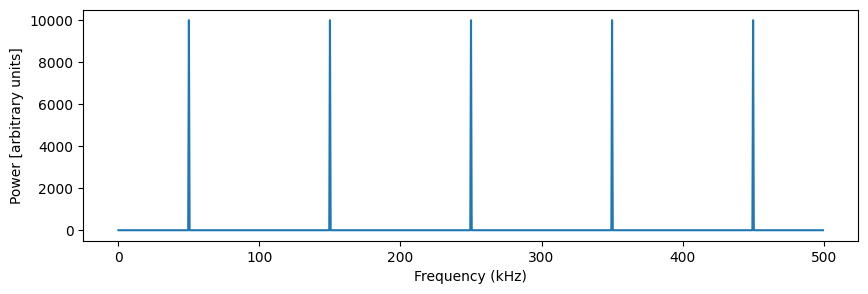

In [7]:
plot_repeated_spectrum(wave)

Next we need to convert to 16 bit signed and store


In [8]:
# renormalize the waveform to peak 16bit signed integer with some headroom
Amax = 2**15*0.99
wave_norm = wave/np.abs(wave).max()*Amax
wave16 = wave_norm.astype(np.int16) # convert to 16bit signed integer
Nw = open(filename,'wb').write(wave16.tobytes())
try:
    assert (Nw==N*2) # 2 bytes per sample
except AssertionError:
    print (f"Something went wrong writing the file. {Nw} bytes written, {2*N} bytes expected.")


# Part 2: Read and check

Text(0, 0.5, 'value')

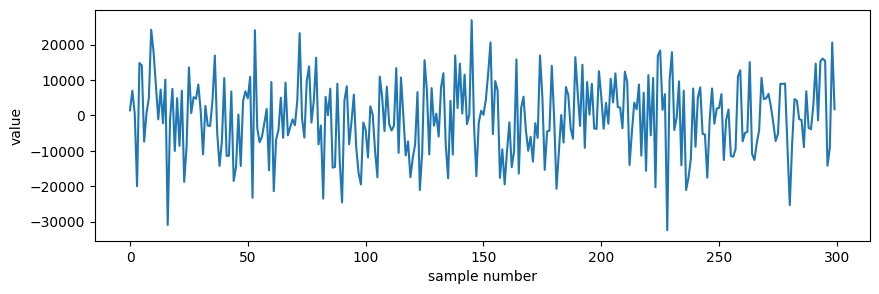

In [9]:
# Read file and plot 
wave = np.fromfile(filename, dtype=np.int16) # read the file
Nplot = 300
plt.figure (figsize=(10,3))
plt.plot(np.arange(Nplot), wave[:Nplot])
plt.xlabel('sample number')
plt.ylabel('value')


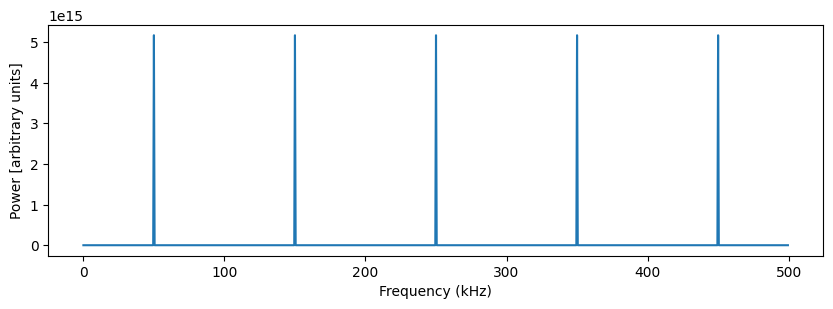

In [10]:
# and the power spectrum
plot_repeated_spectrum(wave)